In [1]:
#!/usr/bin/env python
# coding: utf-8

# -*- coding: utf-8 -*-
import pandas as pd
from pandas.errors import ParserError
import numpy as np
import os, collections
import matplotlib.pyplot as plt

In [2]:
DATA_SET_DIR = '../DATA/Filtered_Feature_Analysis/'

In [5]:
def mkdir(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

In [3]:
def plot_k_distance_to_tss(dist_dir, fig_dir):
    EACH_SUB_FIG_SIZE = 4
    methy_categories = ["LM", "IM", "HM"]
    N_ROW = len(methy_categories)

    k_categories = ["K_0_5", "K_5_15", "K_15_25", "K_25_35", "K_35_45", "K_45_55", "K_55_65",
                    "K_65_75", "K_75_85", "K_85_95", "K_95_100", ""]
    N_COL = len(k_categories)
    N_BIN = 100
    fig, axs = plt.subplots(N_ROW, N_COL, figsize=(N_COL * EACH_SUB_FIG_SIZE, N_ROW * EACH_SUB_FIG_SIZE))
    for i, methy_class in enumerate(methy_categories):
        for j, k_class in enumerate(k_categories):
            ax = axs[i][j]
            if k_class != "":
                input_fp = os.path.join(dist_dir, "%s_%s.tsv" %( methy_class, k_class))
            else:
                input_fp = os.path.join(dist_dir, "%s.tsv" % (methy_class))
            df = pd.read_csv(input_fp, sep="\t", header=None).values
            dists = df[:, -1]
            k_within_5kb_to_tss = dists[dists < 5000]
            proportion_of_k_out_5kb_to_tss = (1. - float(len(k_within_5kb_to_tss))/ len(dists)) * 100.0
            ax.hist(dists, N_BIN, density=True, facecolor='b', alpha=0.75)
            ax.text(50000, 0.00003, "%.0f%% k > 5kb" % proportion_of_k_out_5kb_to_tss)
            ax.set_xlim([-250000, 250000])
            ax.set_ylim([0, 0.000045])
            ax.set_xticks([])
            if i == 0:
                if k_class != "":
                    ax.set_title("%s" % k_class)
                else:
                    ax.set_title("%s" % "All")
            elif i == len(methy_categories) - 1:
                ax.set_xlabel("Dist to TSS")
                ax.set_xticks([-150000, 0, 150000])
            if j == 0:
                ax.set_ylabel('%s' % methy_class)
            else:
                ax.set_yticks([])
    plt.savefig(os.path.join(fig_dir, "K_distance_to_TSS.png"), dpi=200)

In [8]:
fig_dir = "../FIGURES/Functional_Analysis"
mkdir(fig_dir)
dist_dir = os.path.join(DATA_SET_DIR, "DATA", "K_DISTANCE_TO_TSS")

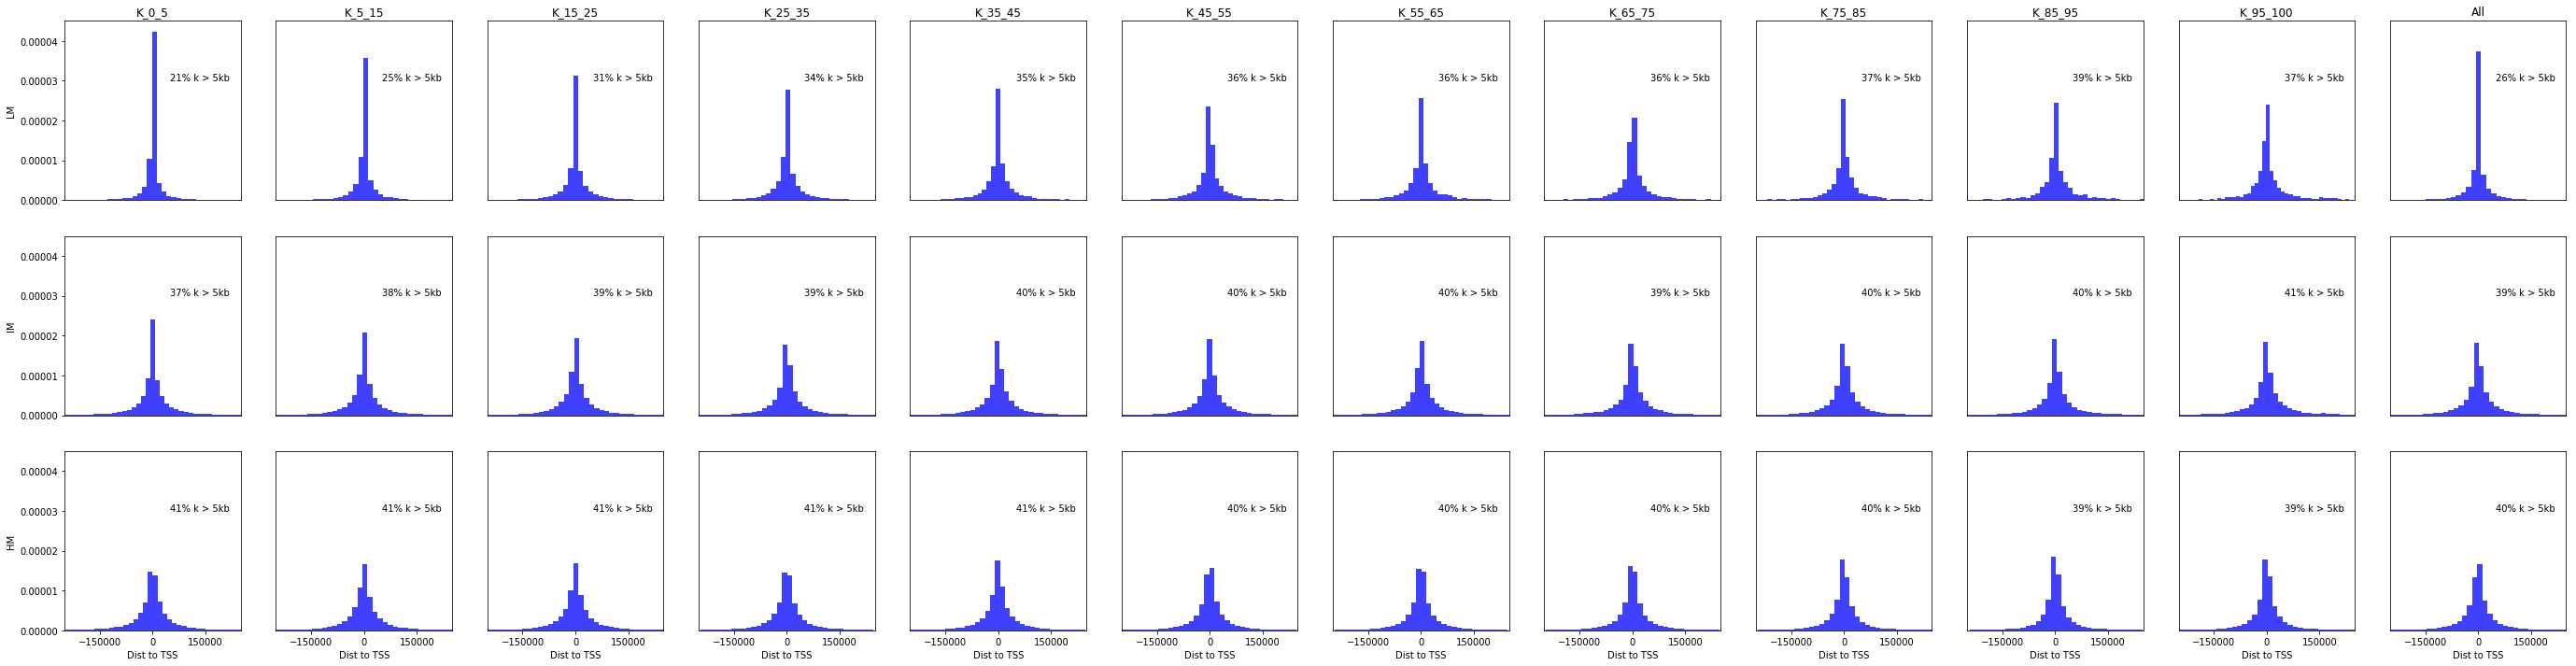

In [9]:
plot_k_distance_to_tss(dist_dir, fig_dir)

In [10]:
def annotation_stack_barplot(dist_dir, fig_dir):
    EACH_SUB_FIG_SIZE = 4
    ChrmoHMM_LABELS = "Active Promoter", "Weak Promoter", "Poised Promoter", "Strong Enhancer", "Strong Enhancer", "Weak Enhancer", "Weak Enhancer", "Insulator", "Txn Transition", "Txn Elongation", "Weak Txn", "Repressed", "Heterochrom/lo", "Repetitive/CNV", "Repetitive/CNV"
    NUMBER_OF_CHRMM_CLASS = len(ChrmoHMM_LABELS)
    chrHMMs = np.arange(NUMBER_OF_CHRMM_CLASS)

    methy_categories = ["LM", "IM", "HM"]
    N_ROW = len(methy_categories)

    k_categories = ["K_0_5", "K_5_15", "K_15_25", "K_25_35", "K_35_45", "K_45_55", "K_55_65",
                    "K_65_75", "K_75_85", "K_85_95", "K_95_100", ""]
    mod_k_categories = [k_categories[i] if i != len(k_categories) - 1 else "All" for i in range(len(k_categories)) ]
    ind = np.arange(len(k_categories))
    cm = plt.get_cmap('gist_rainbow')
    fig, axs = plt.subplots(N_ROW, 1, figsize=(EACH_SUB_FIG_SIZE * 5, N_ROW * EACH_SUB_FIG_SIZE))
    for i, methy_class in enumerate(methy_categories):
        ax = axs[i]
        class_data = np.zeros((NUMBER_OF_CHRMM_CLASS, len(k_categories)))
        for j, k_class in enumerate(k_categories):
            if k_class != "":
                input_fp = os.path.join(dist_dir, "%s_%s.bed" %( methy_class, k_class))
            else:
                input_fp = os.path.join(dist_dir, "%s.bed" % (methy_class))
            df = pd.read_csv(input_fp, sep="\t", header=None).values
            classes = df[:, -1]
            unique, counts = np.unique(classes, return_counts=True)
            normed_counts = counts / float(counts.sum())
            unique_dc = dict(zip(unique, normed_counts))
            for cls in chrHMMs:
                if cls + 1 in unique_dc.keys():
                    class_data[cls][j] = unique_dc[cls + 1]
                else:
                    class_data[cls][j] = 0.
        pls = []
        for cls in chrHMMs:
            if cls == 0:
                pl = ax.bar(ind, tuple(list(class_data[cls, :])), 0.35)
            else:
                sum_prev = list(np.sum(class_data[0: cls, :], axis=0))
                pl = ax.bar(ind, tuple(list(class_data[cls, :])), 0.35, bottom=tuple(sum_prev))
            for item in pl:
                item.set_color(cm(1. * cls / NUMBER_OF_CHRMM_CLASS))
            pls.append(pl)
        ax.set_ylabel('Percentage in %s' % methy_class)
        ax.set_xticks(ind)
        ax.set_xticklabels(mod_k_categories)
        ax.set_yticks(np.arange(0.2, 1.1, 0.2))
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.7, box.height])
        if i == 0:
            ax.legend(tuple(pls), tuple(ChrmoHMM_LABELS), loc='center left', bbox_to_anchor=(1, 0.5))
        elif i == len(methy_class) - 1:
            ax.set_xlabel('ChromHMM')
    plt.savefig(os.path.join(fig_dir, "ChromoHMM.png"), dpi=200)

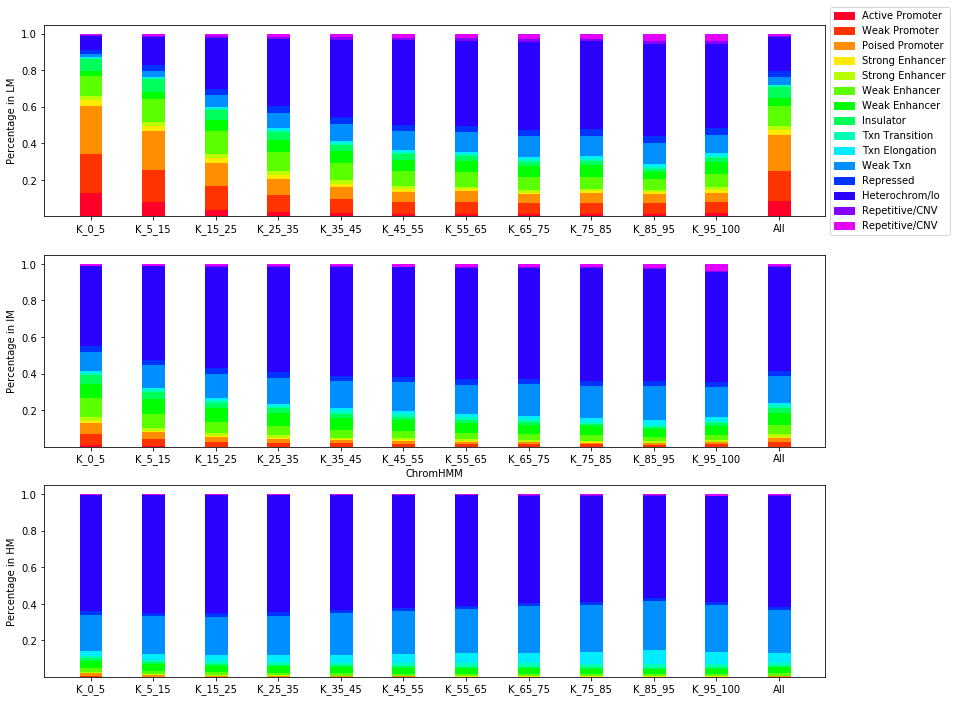

In [11]:
annotation_stack_barplot(dist_dir, fig_dir)